Consider the data set you have received in your e-mail, which is of the form (t,y(t)). Try
to fit the following model to the given data set:
$$y(t) = \alpha_2 + \alpha_2e^{\beta t} + \epsilon(t)$$
Let us assume that ${\epsilon(t)}$ is a sequence of i.i.d. normal random variable with mean zero and
finite variance. Analyze the data keeping the following points in mind, and write a report
based on that.
1. Plot the data.
2. Plot the residual sum of squares as a function of β.
3. Find the least squares estimators of α1, α2 and β based on the Gauss-Newton method.
Clearly mention which initial value you are taking? Does your result affect by the
choice of the initial guess?
4. Find the estimate of σ2.
5. Find the associated confidence intervals based on the Fisher information matrix.
6. Plot the residuals.
7. Test whether it satisfies the normality assumption or not?
8. Use any standard package (say R) and try to obtain the least squares estimators of
the unknown parameters based on three dimensional optimization problem. Repeat
all the above questions. Indicate which initial values you are taking and why?
9. What will you do to fit the following model
$$
y(t) = \alpha_1 e^{\beta_1 t} + \alpha_2 e^{\beta_2 t} + \epsilon(t)
$$
to the same data set? Let us assume that $\epsilon(t)$ satisfies the same assumption as above.

### setup

In [415]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [416]:

data=pd.read_csv('data-39.txt',header=None,sep=r'\s+')
# use regex expressions

In [417]:
x=data.iloc[:,0]
y=data.iloc[:,1]

In [418]:
data.head()

,0,1
0,0.02,2.3031
1,0.03,2.3992
2,0.05,2.3923
3,0.06,2.4571
4,0.08,2.3859


### 1

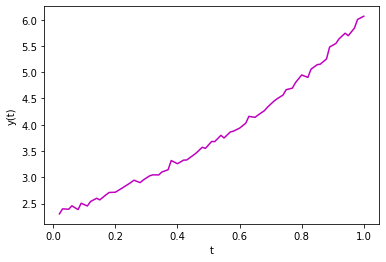

In [419]:
plt.plot(x,y,c='m')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.savefig('plots/q1.png')
plt.show()

### 2

minimum sse 0.11726358664701811


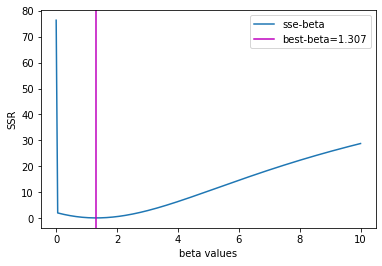

In [420]:
'''how one chooses which beta points to consider: trial and error'''
beta_points=np.linspace(0,10,200) 
sse_points=[]
for beta_fixed in beta_points:
    x_fixed=np.exp(beta_fixed*x)
    y_fixed=y
    tmp_data=pd.DataFrame({'t':x_fixed,'y_t':y_fixed})
    model=smf.ols('y_t ~ t',tmp_data).fit()
    # sse_value=sum((model.fittedvalues-np.mean(tmp_data['y_t']))**2)
    sse_value=sum((model.fittedvalues-tmp_data['y_t'])**2)
    sse_points.append(sse_value)

min_sse=min(sse_points)
print('minimum sse',min_sse)
best_beta=beta_points[sse_points.index(min_sse)]
plt.plot(beta_points,sse_points,label='sse-beta')
plt.axvline(best_beta,label='best-beta='+str(round(best_beta,3)),c='m')
plt.xlabel('beta values')
plt.ylabel('SSR')
plt.legend()
plt.savefig('plots/q2.png')
plt.show()

For $\beta$, we choose the value of $\beta$ that gives minimum residual sum of squares in part-2. If we fix $\beta$ then we have a simple linear regression model. We get initial values for $\alpha_1, \alpha_2$ by OLS method.

When we have all parameters we can compute SSR, and then plot it against $\beta$.

### 3

In [421]:
def get_residual(params,y=y,x=x):
    """
    function to get residual value
    """
    alpha1=params[0]
    alpha2=params[1]
    beta=params[2]

    y_estimate=alpha1+alpha2*np.exp(beta*x)

    ssr=sum((y_estimate-y)**2)

    return ssr

In [422]:
def gauss_newton(start_theta,n_iter=1000):
    """
    TODO: need to implement such that it can handle singular matrices 
    TODO: implement step factor version
    """
    curr_theta=start_theta
    thetas_values=[curr_theta]
    ssr_values=[get_residual(curr_theta)]
    for i in range(n_iter):
        # print(i)
        step_factor=1
        curr_alpha1=curr_theta[0]
        curr_alpha2=curr_theta[1]
        curr_beta=curr_theta[2]

        e_beta1=sum(np.exp(curr_beta*x))
        e_beta2=sum(np.exp(2*curr_beta*x))
        # F^T.F    
        C_matrix=np.array([
            [len(x),e_beta1,curr_beta*curr_alpha2*e_beta1],
            [e_beta1,e_beta2,curr_beta*curr_alpha2*e_beta2],
            [curr_beta*curr_alpha2*e_beta1,curr_beta*curr_alpha2*e_beta2,(curr_beta**2)*(curr_alpha2**2)*e_beta2]
        ])
    
        F_matrix=np.array([
            [1]*len(x),
            np.exp(curr_beta*x),
            curr_beta*curr_alpha2*np.exp(curr_beta*x)
        ])
        curr_theta=curr_theta+np.dot(np.dot(np.linalg.inv(C_matrix),F_matrix),np.array(y-(curr_alpha1+curr_alpha2*np.exp(curr_beta*x))))
        tmp_ssr_value=get_residual(curr_theta)
        """
        only considering thoes steps that lower ssr value
        """
        if tmp_ssr_value<=ssr_values[-1]:
            thetas_values.append(curr_theta)
            ssr_values.append(tmp_ssr_value)
    return {'theta_values':thetas_values,'ssr_values':ssr_values}

simple ans is that convergence itself depends on the starting values, and when values are bad it just goes out of bounds like really small or large values.

starting value for beta needs to be good enough then we can get linear estimates of \alpha_1 and \alpha_2

one solution is to only consider theta improvements measured by ssr value

also can try with step factor modification

In [423]:
# start values
beta_start=best_beta
x_fixed=np.exp(beta_start*x)
y_fixed=y
tmp_data=pd.DataFrame({'t':x_fixed,'y_t':y_fixed})
model=smf.ols('y_t ~ t',tmp_data).fit()

a1=model.params[0]
a2=model.params[1]

tmp_estimate=gauss_newton(np.array([a1,a2,beta_start]))

In [424]:
chain_result=gauss_newton(np.array([3,0.2,2.5]))
theta_estimate=chain_result['theta_values'][-1]

- it is very sensetive to the starting value of theta
- how do we get good starting value for this method
    - might use linear algebra estimated values; or might use values that are near to linear-model fitted values
- theoratically we should converge if we have good start and give algo enough time to run 

### 4

$$\hat{\sigma^2}=\frac{1}{n-p}(y-f(\hat{\theta}))^TV^{-1}(y-f(\hat{\theta})) $$
Here $p=3$ and $V^{-1}=I$

In [425]:
# lse values obtained from gauss approximation
alpha1_lse=theta_estimate[0]
alpha2_lse=theta_estimate[1]
beta_lse=theta_estimate[2]

In [426]:
n=len(y)
p=3
sigma_estimate=(1/(n-p))*sum((y-(alpha1_lse+alpha2_lse*np.exp(beta_lse*x)))**2)

In [427]:
sigma_estimate

0.0019151129746739592

### 5

$$\sqrt{n}(\hat{\Theta}-\Theta) \sim \mathcal{N}_{p+1}(0,I^{-1})$$
Here $I^{-1}$ is inverse of fisher information matrix. $p=3$ and $\Theta=(\theta,\sigma^2)$

In [428]:
# get confidence intervals
c=1.96 # for 95% confidence interval

curr_alpha1=alpha1_lse
curr_alpha2=alpha2_lse
curr_beta=beta_lse

e_beta1=sum(np.exp(curr_beta*x))
e_beta2=sum(np.exp(2*curr_beta*x))

C_matrix=np.array([
    [len(x),e_beta1,curr_beta*curr_alpha2*e_beta1],
    [e_beta1,e_beta2,curr_beta*curr_alpha2*e_beta2],
    [curr_beta*curr_alpha2*e_beta1,curr_beta*curr_alpha2*e_beta2,(curr_beta**2)*(curr_alpha2**2)*e_beta2]
])

inv_C_matrix=sigma_estimate*np.linalg.inv(C_matrix)

In [429]:
[sigma_estimate-c*np.sqrt((2*sigma_estimate**2)/(len(x))),sigma_estimate+c*np.sqrt((2*sigma_estimate**2)/(len(x)))]

[0.0012566842192857988, 0.0025735417300621196]

In [430]:
[alpha1_lse-c*np.sqrt(inv_C_matrix[0][0]),alpha1_lse+c*np.sqrt(inv_C_matrix[0][0])]

[0.8172712450640579, 0.8794758938480357]

In [431]:
[alpha2_lse-c*np.sqrt(inv_C_matrix[1][1]),alpha2_lse+c*np.sqrt(inv_C_matrix[1][1])]

[-265084.2064258973, 265087.11151459976]

In [432]:
[beta_lse-c*np.sqrt(inv_C_matrix[2][2]),beta_lse+c*np.sqrt(inv_C_matrix[2][2])]

[-142639.2637830291, 142641.8226272242]

### 6

In [433]:
residuals=y-(alpha1_lse+alpha2_lse*np.exp(beta_lse*x))

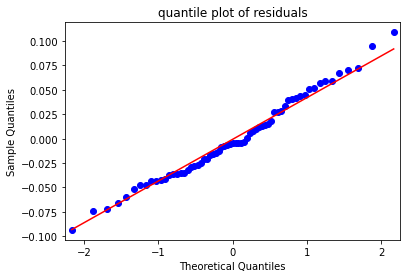

In [434]:
sm.ProbPlot(residuals).qqplot(line='s')
plt.title('quantile plot of residuals')
plt.savefig('plots/q6-1.png')
plt.show()

If the residuals are normally distributed, the data points of the normal probability plot will fall along a straight
line. Major deviations from this ideal picture reflect departures from normality. Stragglers at either end of the
normal probability plot indicate outliers, curvature at both ends of the plot indicates long or short distributional
tails, convex or concave curvature indicates a lack of symmetry, and gaps, plateaus, or segmentation in the normal
probability plot may require a closer examination of the data or model. We do not recommend that you use this
diagnostic with small sample sizes.

### 7

by normality assumption we mean:

    the residuals should be approximately normal
    the residuals should have the same variance
    the residuals should be independent

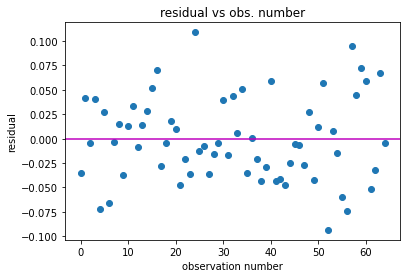

In [435]:
plt.plot(residuals,linestyle='none',marker='o')
plt.axhline(0,c='m')
plt.xlabel('observation number')
plt.ylabel('residual')
plt.title('residual vs obs. number')
plt.savefig('plots/q6-2.png')
plt.show()

residuals seems to have homogeneous variance 

When the row number can be equated to time period, this plot lets you see if there is a pattern across time.

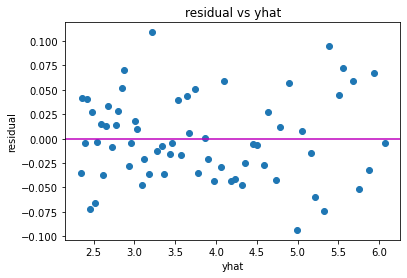

In [436]:
plt.scatter(alpha1_lse+alpha2_lse*np.exp(beta_lse*x),residuals)
plt.axhline(0,c='m')
plt.xlabel('yhat')
plt.ylabel('residual')
plt.title('residual vs yhat')
plt.savefig('plots/q6-3.png')
plt.show()

This plot should always be examined. The preferred pattern to look for is a point cloud or a horizontal band. A
wedge or bowtie pattern is an indicator of nonconstant variance. A sloping or curved band signifies inadequate
specification of the model. A sloping band with increasing or decreasing variability could suggest nonconstant
variance and inadequate specification of the model.

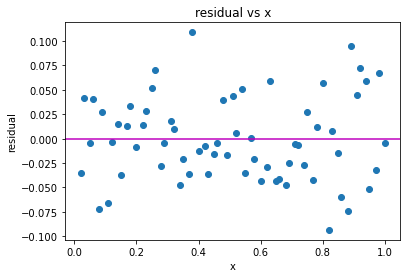

In [437]:
plt.scatter(x,residuals)
plt.axhline(0,c='m')
plt.xlabel('x')
plt.ylabel('residual')
plt.title('residual vs x')
plt.savefig('plots/q6-4.png')
plt.show()

This is a scatter plot of the residuals versus each independent variable. Again, the preferred pattern is a
rectangular shape or point cloud. Any nonrandom pattern may require a redefining of the model.

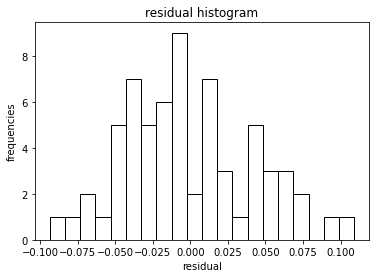

In [438]:
plt.hist(residuals,bins=20,fill=False)
plt.xlabel('residual')
plt.ylabel('frequencies')
plt.title('residual histogram')
plt.savefig('plots/q6-5.png')
plt.show()

residuals also seem to be approximatly normally distributed 

### 8

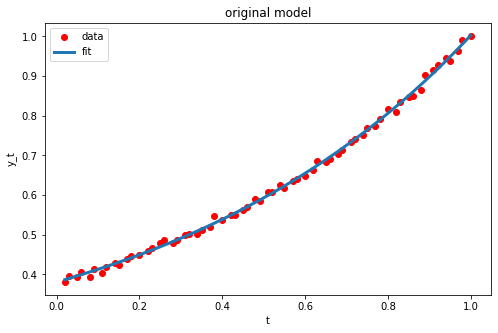

In [439]:
def f(x,alpha1,alpha2,beta):
    y=alpha1+alpha2*np.exp(beta*x)
    return y

y_data=y/max(y)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, x, y_data)# Now we plot our resulting regression model.

plt.figure(figsize=(8,5))
y_norm= f(x,*popt)
# print(y_norm)
plt.plot(x,y_data, 'ro', label='data')
plt.plot(x,y_norm, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('y_t')
plt.xlabel('t')
plt.title('original model')
plt.savefig('plots/q8-1.png')
plt.show()

In [440]:
popt

array([0.15296613, 0.22786173, 1.31606528])

In [441]:
# lse values obtained from gauss approximation
alpha1_lse=popt[0]
alpha2_lse=popt[1]
beta_lse=popt[2]
n=len(y)
p=3
sigma_estimate=(1/(n-p))*sum((y-(alpha1_lse+alpha2_lse*np.exp(beta_lse*x)))**2)
sigma_estimate

11.54092901904606

In [442]:

c=1.96 # for 95% confidence interval

curr_alpha1=alpha1_lse
curr_alpha2=alpha2_lse
curr_beta=beta_lse

e_beta1=sum(np.exp(curr_beta*x))
e_beta2=sum(np.exp(2*curr_beta*x))

C_matrix=np.array([
    [len(x),e_beta1,curr_beta*curr_alpha2*e_beta1],
    [e_beta1,e_beta2,curr_beta*curr_alpha2*e_beta2],
    [curr_beta*curr_alpha2*e_beta1,curr_beta*curr_alpha2*e_beta2,(curr_beta**2)*(curr_alpha2**2)*e_beta2]
])

inv_C_matrix=sigma_estimate*np.linalg.inv(C_matrix)



In [443]:
[sigma_estimate-c*np.sqrt((2*sigma_estimate**2)/(len(x))),sigma_estimate+c*np.sqrt((2*sigma_estimate**2)/(len(x)))]

[7.573079795254298, 15.50877824283782]

In [444]:
[alpha1_lse-c*np.sqrt(inv_C_matrix[0][0]),alpha1_lse+c*np.sqrt(inv_C_matrix[0][0])]

[-2.203784923996614, 2.5097171749476272]

In [445]:
[alpha2_lse-c*np.sqrt(inv_C_matrix[1][1]),alpha2_lse+c*np.sqrt(inv_C_matrix[1][1])]

[nan, nan]

In [446]:
[beta_lse-c*np.sqrt(inv_C_matrix[2][2]),beta_lse+c*np.sqrt(inv_C_matrix[2][2])]

[nan, nan]

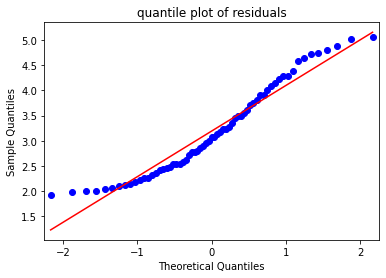

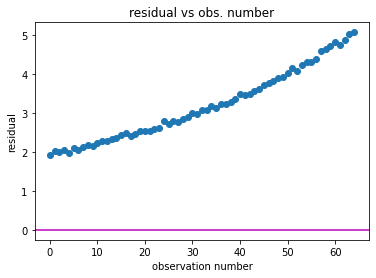

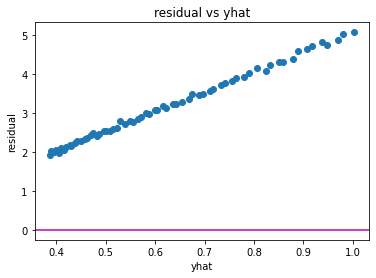

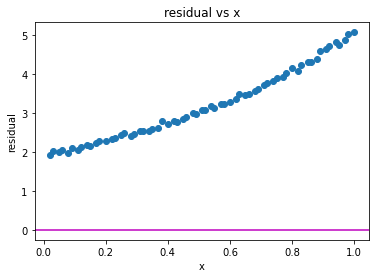

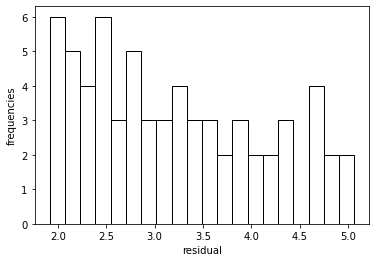

In [447]:

### 6
residuals=y-(alpha1_lse+alpha2_lse*np.exp(beta_lse*x))
sm.ProbPlot(residuals).qqplot(line='s')
plt.title('quantile plot of residuals')
plt.show()

plt.plot(residuals,linestyle='none',marker='o')
plt.axhline(0,c='m')
plt.xlabel('observation number')
plt.ylabel('residual')
plt.title('residual vs obs. number')
plt.show()

plt.scatter(alpha1_lse+alpha2_lse*np.exp(beta_lse*x),residuals)
plt.axhline(0,c='m')
plt.xlabel('yhat')
plt.ylabel('residual')
plt.title('residual vs yhat')
plt.show()

plt.scatter(x,residuals)
plt.axhline(0,c='m')
plt.xlabel('x')
plt.ylabel('residual')
plt.title('residual vs x')
plt.show()

plt.hist(residuals,bins=20,fill=False)
plt.xlabel('residual')
plt.ylabel('frequencies')
plt.show()

### 9

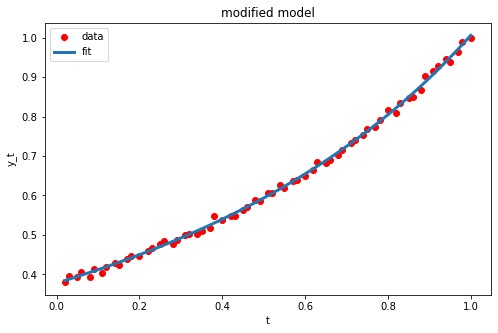

In [448]:
def f_mod(x,alpha1,alpha2,beta1,beta2):
    y=alpha1*np.exp(beta1*x)+alpha2*np.exp(beta2*x)
    return y

y_data=y/max(y)
from scipy.optimize import curve_fit
popt, pcov = curve_fit(f_mod, x, y_data)
# Now we plot our resulting regression model.

plt.figure(figsize=(8,5))
y_norm= f_mod(x,*popt)
# print(y_norm)
plt.plot(x,y_data, 'ro', label='data')
plt.plot(x,y_norm, linewidth=3.0, label='fit')
plt.legend(loc='best')
plt.ylabel('y_t')
plt.xlabel('t')
plt.title('modified model')
plt.savefig('plots/q9-1.png')
plt.show()

In [449]:
# model fitted values
popt

array([0.35676403, 0.02127987, 0.76035054, 2.43343039])